lab4_MNIST

Решить задачу классификации датасета MNIST используя MLP из scikitlearn и используя CNN (по типу LeNet) c пакетом PyTorch.

Сравнить результаты по метрикам, сделать обоснованные выводы



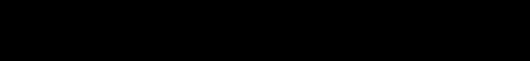
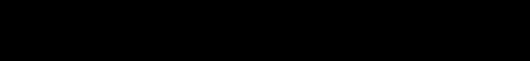
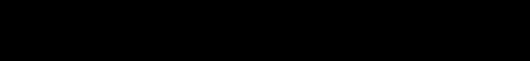
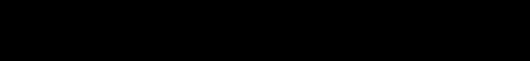

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

plt.rcParams["figure.figsize"] = (8, 5)
np.random.seed(42)


In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist.data.astype(np.float32) / 255.0
y = mnist.target.astype(np.int64)

# стандартное разбиение MNIST: 60k train, 10k test
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((60000, 784), (10000, 784), (60000,), (10000,))

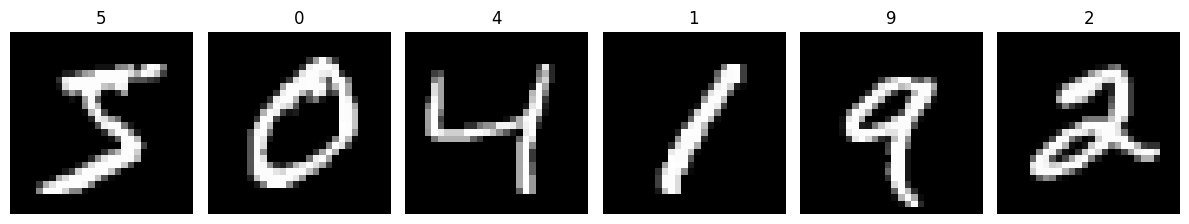

In [3]:
# Визуализация примеров
fig, axes = plt.subplots(1, 6, figsize=(12, 2.5))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(str(y_train[i]))
    ax.axis("off")
plt.tight_layout()
plt.show()


### Заключение по визуализации данных

Визуализация примеров изображений из обучающей выборки подтверждает корректность загрузки датасета MNIST. Изображения цифр хорошо различимы, классы соответствуют ожидаемым значениям, что указывает на отсутствие ошибок в процессе загрузки и предобработки данных.


Используем `MLPClassifier`. Для MNIST важно:
- нормализация/стандартизация входа (добавим `StandardScaler`);
- `early_stopping=True` чтобы не переобучаться и не ждать слишком долго;
- разумная архитектура (256, 128) как baseline.


In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        solver="adam",
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=20,
        early_stopping=True,
        n_iter_no_change=3,
        verbose=True,
        random_state=42
    ))
])

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp, rec_mlp, f1_mlp, _ = precision_recall_fscore_support(y_test, y_pred_mlp, average="macro", zero_division=0)

print("MLP (sklearn) metrics:")
print("Accuracy:", acc_mlp)
print("Precision_macro:", prec_mlp)
print("Recall_macro:", rec_mlp)
print("F1_macro:", f1_mlp)


Iteration 1, loss = 0.29334085
Validation score: 0.956500
Iteration 2, loss = 0.09863696
Validation score: 0.962000
Iteration 3, loss = 0.05893268
Validation score: 0.967167
Iteration 4, loss = 0.03920817
Validation score: 0.965667
Iteration 5, loss = 0.02465275
Validation score: 0.968333
Iteration 6, loss = 0.01658263
Validation score: 0.969333
Iteration 7, loss = 0.01431763
Validation score: 0.971333
Iteration 8, loss = 0.01074474
Validation score: 0.966667
Iteration 9, loss = 0.01612496
Validation score: 0.966833
Iteration 10, loss = 0.01845096
Validation score: 0.963167
Iteration 11, loss = 0.02066228
Validation score: 0.964500
Validation score did not improve more than tol=0.000100 for 3 consecutive epochs. Stopping.
MLP (sklearn) metrics:
Accuracy: 0.9752
Precision_macro: 0.9749455868171824
Recall_macro: 0.9750258103036582
F1_macro: 0.9749728600079015


In [5]:
# Матрица ошибок и отчет (MLP)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print("Confusion matrix (MLP):\n", cm_mlp)

print("\nClassification report (MLP):")
print(classification_report(y_test, y_pred_mlp, digits=4))


Confusion matrix (MLP):
 [[ 970    0    0    1    1    1    2    1    3    1]
 [   0 1125    3    2    0    1    2    1    1    0]
 [   6    2  999    2    3    1    6    7    6    0]
 [   0    0    4  984    0    8    2    3    3    6]
 [   0    0    3    3  957    1    5    4    1    8]
 [   3    0    0    6    1  869    5    0    5    3]
 [   4    3    2    1    3    2  941    0    2    0]
 [   0    3    7    2    0    1    0 1000    4   11]
 [   4    0    2   10    7    8    2    3  933    5]
 [   2    2    0    7    6    4    0   10    4  974]]

Classification report (MLP):
              precision    recall  f1-score   support

           0     0.9808    0.9898    0.9853       980
           1     0.9912    0.9912    0.9912      1135
           2     0.9794    0.9680    0.9737      1032
           3     0.9666    0.9743    0.9704      1010
           4     0.9785    0.9745    0.9765       982
           5     0.9699    0.9742    0.9720       892
           6     0.9751    0.9823  

CNN LeNet (PyTorch)

Архитектура LeNet (адаптация под 28×28):
- Conv(1→6, 5×5) → ReLU → AvgPool(2×2)
- Conv(6→16, 5×5) → ReLU → AvgPool(2×2)
- FC(16·4·4→120) → ReLU → FC(120→84) → ReLU → FC(84→10)

Обучение: CrossEntropyLoss + Adam.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(test_loader)


100%|██████████| 9.91M/9.91M [00:04<00:00, 2.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 246kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


(469, 40)

### Заключение по архитектуре CNN (LeNet)

Используемая сверточная нейронная сеть основана на архитектуре LeNet и включает два сверточных слоя с последующим pooling, а также три полносвязных слоя. Такая архитектура позволяет эффективно извлекать локальные признаки изображений, такие как штрихи и контуры, что особенно важно для задач распознавания рукописных цифр.


In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)   # 28->24
        self.pool  = nn.AvgPool2d(2, 2)               # 24->12
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 12->8
        # pool: 8->4
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

cnn = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

cnn


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    all_true, all_pred = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        all_pred.append(pred)
        all_true.append(yb.numpy())
    return np.concatenate(all_true), np.concatenate(all_pred)

EPOCHS = 3  # при GPU можно поставить 5-10
for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(cnn, train_loader)
    y_true_cnn, y_pred_cnn = eval_model(cnn, test_loader)
    acc = accuracy_score(y_true_cnn, y_pred_cnn)
    print(f"Epoch {epoch}/{EPOCHS} | loss={loss:.4f} | test_acc={acc:.4f}")


C:\Users\Firo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/3 | loss=0.5544 | test_acc=0.9352


C:\Users\Firo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/3 | loss=0.1727 | test_acc=0.9647


C:\Users\Firo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/3 | loss=0.1103 | test_acc=0.9743


In [10]:
acc_cnn = accuracy_score(y_true_cnn, y_pred_cnn)
prec_cnn, rec_cnn, f1_cnn, _ = precision_recall_fscore_support(y_true_cnn, y_pred_cnn, average="macro", zero_division=0)

print("CNN (LeNet) metrics:")
print("Accuracy:", acc_cnn)
print("Precision_macro:", prec_cnn)
print("Recall_macro:", rec_cnn)
print("F1_macro:", f1_cnn)


CNN (LeNet) metrics:
Accuracy: 0.9743
Precision_macro: 0.9740067713258906
Recall_macro: 0.9742689819231861
F1_macro: 0.9740718599760985


In [11]:
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
print("Confusion matrix (CNN):\n", cm_cnn)

print("\nClassification report (CNN):")
print(classification_report(y_true_cnn, y_pred_cnn, digits=4))


Confusion matrix (CNN):
 [[ 963    0    1    0    1    3    4    1    5    2]
 [   0 1125    1    2    0    2    2    0    3    0]
 [   4    3  998    6    1    2    2    7    9    0]
 [   0    0    3  971    0   17    0    6    7    6]
 [   0    0    2    0  966    0    5    2    0    7]
 [   2    1    0    6    0  876    3    1    1    2]
 [   5    3    0    0    4   10  932    0    4    0]
 [   1    6    9    4    2    0    0  991    4   11]
 [   2    0    0    2    4    6    2    1  952    5]
 [   0    7    0    2   19    9    0    3    0  969]]

Classification report (CNN):
              precision    recall  f1-score   support

           0     0.9857    0.9827    0.9842       980
           1     0.9825    0.9912    0.9868      1135
           2     0.9842    0.9671    0.9756      1032
           3     0.9778    0.9614    0.9695      1010
           4     0.9689    0.9837    0.9763       982
           5     0.9470    0.9821    0.9642       892
           6     0.9811    0.9729  

## Сравнение результатов и выводы

### Почему CNN обычно лучше на MNIST
- MLP работает с вектором из 784 признаков и **не учитывает геометрию** изображения.
- CNN (LeNet) использует **свёртки**, которые извлекают локальные признаки (штрихи, углы, контуры), и pooling, повышающий устойчивость к небольшим сдвигам.




In [12]:
results = {
    "MLP_sklearn": {"accuracy": float(acc_mlp), "precision_macro": float(prec_mlp), "recall_macro": float(rec_mlp), "f1_macro": float(f1_mlp)},
    "CNN_LeNet":   {"accuracy": float(acc_cnn), "precision_macro": float(prec_cnn), "recall_macro": float(rec_cnn), "f1_macro": float(f1_cnn)},
}
results


{'MLP_sklearn': {'accuracy': 0.9752,
  'precision_macro': 0.9749455868171824,
  'recall_macro': 0.9750258103036582,
  'f1_macro': 0.9749728600079015},
 'CNN_LeNet': {'accuracy': 0.9743,
  'precision_macro': 0.9740067713258906,
  'recall_macro': 0.9742689819231861,
  'f1_macro': 0.9740718599760985}}